# Hamiltonian Monte Carlo

As seen in previous notebooks, Metropolis sampler with proposals generated by random-walk has few (related) problems:
    - it fails in many dimensional problems
    - it often proposes states with low probability, resulting in high rejection rates

To solve these problems, sampling algorithm called Hamiltonian Monte Carlo was developed ([wiki](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)). There are two possible intuitive motivations for how it should work. One is purely abstract:

Random walk metropolis proposes unprobable states because the exploration of the state-space is *blind*- the proposal process is completely independent on the density distribution (only rejection-acceptance depends on it). We may solve this problem by taking the shape of the distribution into account when proposing states, for example by letting the gradient of the distribution guide us towards more probable states (more accurately, towards the states with the highest contribution to any integration, i.e.: typical set).
This motivation is explained in detail in [[1](https://arxiv.org/pdf/1701.02434.pdf)] (great paper, give it a try).

Another motivation is based on analogy with physics- ordinary physical systems are great at sampling from random distributions. For example a movement of an atom in a gas- its movement consists of two processes:
    - movement according to Newton's laws of motion under the influence of external potential field (completely deterministic).
    - random collisions with other particles in a gas
    
With this process, probability distribution of the particle's position and velocity will be such, that:

$$ \begin{aligned} P(x) \propto e^{-\frac{U(x)}{T}} \\
P(v) \propto e^{-\frac{K(v)}{T}}
\end{aligned}$$

where $U(x)$ is potential energy of the particle, $K(v)$ is it's kinetic energy (in general, it may also depend on $x$, but for an atom in a gas, it depends only on $v$) and $T$ temperature of the system. In physics this formula is called Boltzman (also canonical) distribution and is valid for all systems in thermal equilibrium, not just particle in a gas [[4](http://assets.cambridge.org/97805218/11194/excerpt/9780521811194_excerpt.pdf)]. So the idea is this: 

** Let's divise such potential $U(x)$ that $P(x)\propto e^{-\frac{U(x)}{T}}$ will be our target distribution ( log probability unexpectedly appears here), simulate the motion of the physical system, add some random collisions (so that $v$ is from $P(v)$) and we should get a valid sampler for $x$.**

Both motivations would lead us to the same sampling algorithm. In this notebook we will show one possible implementation of such sampler, introduce some theoretical concepts usefull for reasoning about it and try it on some problem where random walk metropolis fails. You can find links to further reading at the end of the notebook.

## Hamiltonian Monte Carlo algorithm

HMC sampler algorithm works conceptually like this:

 - devise suitable (physical) system with potential energy $U(x)/T=-log(P(x))$
 - at each step:
    - give the system random kick (keeping in mind that distribution of velocity is P(v))
    - simulate its evolution according to mechanical laws of motion for some predetermined time
    - correct numerical errors
    - return its position
    
We will now go through these steps (in slightly different order).
### Simulation of the time evolution of the system
The HMC is named by the fact that time evolution of the system is usually described using Hamiltonian formulation of classical mechanics. If a system has potential energy $U(x)$ and kinetic energy $K(x,p)$, it's total energy (also called hamiltonian) is $H=U(x)+K(x,p)$, where $x$ and $p$ are generalised position and momentum vectors (can be many dimensional). Then the evolution of the system in time will be a solution of these equations:
 $$\begin{aligned}\dot{x} &= \frac{\partial H}{\partial p} \\
\dot{p} &= - \frac{\partial H}{\partial x}
\end{aligned}$$

For mechanical systems, these equations are just a reformulation of ordinary laws of motion- the first one is definition of momentum in terms of velocity and second equation is the second Newton's law (with $- \frac{d U(x)}{d x}$ being the force acting on the system). Hamiltonian formulation is used because:
 - equations of motion have elegant symmetry that makes theoretical proofs easier
 - energy is natural concept in Hamiltonian formulation, which is good for us because potential energy corresponds directly to target probability distribution
 
Good way to solve (integrate) these equations numerically is *leapfrog algorithm* (also called Velocity-Verlet and many other different names). It has one property quite important for this application: it conserves the energy of the system over long integration times, thus avoiding the slow drift in total energy due to finite time step. One can find claims that it's due to time reversibility of the leapfrog algorithm. This [link](http://physics.ucsc.edu/~peter/242/leapfrog.pdf) suggests it's not the only necessary condition.

Single step of leapfrog algorithm for the equations above (with time step $\delta$) looks like this:

 $$\begin{aligned} p(t+\frac{\delta}{2}) &= p(t)-\frac{\delta}{2} \frac{\partial H}{\partial x}\Bigr|_{t} \\
 x(t+\delta) &= x(t) + \delta \frac{\partial H}{\partial p}\Bigr|_{t+\frac{\delta}{2}}\\
 p(t+\delta) &= p(t+\frac{\delta}{2})-\frac{\delta}{2} \frac{\partial H}{\partial x}\Bigr|_{t+\delta}\end{aligned}$$

Keep in mind that this algorithm doesn't prevent numerical errors due to rounding, just drift in energy due to finite time step, so the rounding error has to be corrected in another step of the HMC.

### Choice of correct physical system ( = correct Hamiltonian)

How to choose hamiltonian which will lead to sampling from my target distribution?  Simplest hamiltonian is that of a single particle in a potential field (=particle in an ideal gas):
$$H(x,v)=U(x)+\frac{1}{2}mv^2$$
where we started to use velocity $v=\dot{x}=\frac{p}{m}$ instead of momentum. **Remember that $x$ and $v$ can be many dimensional vectors (both with the same number of dimensions).** Hamiltonians with different kinetic energy term can lead to the same distribution $P(x)$ (see the Appendix), however this choice is usually the most natural and easiest.
HMC with this hamiltonian will lead to probability distribution $ P(x)= \frac{1}{Z} e^{-\frac{U(x)}{T}}$, so if we set $T=1$, we  just have to choose U(x)=-log(P(x)) (normalization constant $Z$ can be safely left out, since it has no effect on the result). 

Equations of motion for this hamiltonian will be simply:

 $$\begin{aligned}\dot{x} &= v \\
\dot{v} &= a= -\frac{1}{m} \frac{d U(x)}{d x}
\end{aligned}$$

(See? Just definition of velocity and Newton's second law, nothing scary.) These equations lead to the following numerical integration scheme (using leapfrog algorithm):

 $$\begin{aligned} v(t+\frac{\delta}{2}) &= v(t)+\frac{\delta}{2}a(t) \\
 x(t+\delta) &= x(t) + \delta v(t+\frac{\delta}{2})\\
 v(t+\delta) &= v(t+\frac{\delta}{2})+\frac{\delta}{2} a(t+\delta)\end{aligned}$$

So in order to use HMC, we will have to supply not only potential function, but also its gradient (or compute it numerically).

### Random perturbations

Without some random perturbation of the system its evolution would be completely deterministic and thus useless for sampling. However, random perturbations must be such that they will lead to the correct sampling of $P(x)$. This will be satisfied if during each "random kick" step, we resample momentum from (Boltzman) probability distribution $P(p)=\frac{1}{Z} exp(-K(x,p)/T)$, where $T$ is temperature (see the Appendix or trust the physics). Since we allready set $T=1$, for hamiltonian above we will sample velocity $v$ from distribution $P(v)=\frac{1}{Z}exp(-\frac{m v^2}{2})$, which is a normal distribution with variance $\sigma^2=\frac{1}{m}$.


### Correction of rounding errors

On an ideal machine, this step would not be necessary, but in reality numerical integration will introduce rounding errors which will in time bias the sampling. Turns out that this can be exactly corrected by adding a Metropolis accept/reject stage after the leapfrog integration [[2](http://www.cs.toronto.edu/~radford/ftp/review.pdf)]. The proposed new state $(x_{prop},p_{prop})$ will be accepted with probability $$\frac{exp(-H(x_{prop},p_{prop}))}{exp(-H(x_{old},p_{old}))}$$. If it's not accepted, the system stays in its old state from before leapfrog integration. 

The fact that this is only correction step means that rejection should be rare and the **HMC should accept almost all proposed states**. This can be seen by the fact that if the integration would be exact, the total energy $H(x(t),p(t))$ would be still the same (since hamiltonian dynamics preserves energy), and the probability of acceptance would be exactly one.


## Implementation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def target_distribution_to_potential(f, gradient_f):
    #doing it by hand is numerically more efficient,
    #but if you are lazy, here is a helper method
    potential=lambda x: -np.log(f(x))
    gradient= lambda x: -gradient_f(x)/f(x)
    return potential,gradient

class HMC_sampler:
    def __init__(self,
                 potential,
                 gradient,
                 num_leapfrog_steps=100,
                 leapfrog_stepsize=0.1,
                 mass=1.):   #inverse of variance of velocity distribution
        
        self.potential=potential
        self.gradient=gradient
        self.acceleration=lambda x: -gradient(x)/self.mass
        self.num_leapfrog_steps=num_leapfrog_steps
        self.leapfrog_stepsize=leapfrog_stepsize
        self.mass=mass
        
    def total_energy(self,x,v):
        return self.potential(x)+0.5*self.mass*np.dot(v,v)
        
    def do_leapfrog_step(self,x,v,a):       # a is for acceleration
        new_v= v + 0.5 * self.leapfrog_stepsize * a
        
        new_x= x + new_v * self.leapfrog_stepsize
        new_a=self.acceleration(new_x)
        
        new_v= new_v + 0.5 * self.leapfrog_stepsize * new_a
        return new_x,new_v,new_a
        
    def should_accept(self, energy, proposed_energy):    
        #since probability=exp(-energy), this is just metropolis criteria  
        u = np.random.uniform()
        return u < np.exp( energy - proposed_energy )    
    
    def sample_velocity(self,shape):
        return np.random.normal(0,(1./self.mass)**0.5,size=shape)
        
    def run(self,x_init,num_steps=1000):
        x_trace=np.zeros(shape=(num_steps,x_init.shape[0]))       
        x_trace[0,:]=x_init
        logs={'x':[],'v':[],'E':[],'rejected':[]}    #just for diagnostics purposes
        
        x=x_init
        for i in range(num_steps):
            #resample velocity (= random kick)
            v=self.sample_velocity(x_init.shape)

            #simulate hamiltonian dynamics with leapfrog algorithm
            #to get proposal values of x and v
            x_prop = x
            v_prop = v 
            a = self.acceleration(x)
            for n in range(self.num_leapfrog_steps):
                x_prop, v_prop, a = self.do_leapfrog_step(x_prop, v_prop,a)
                logs['x'].append(x_prop)
                logs['v'].append(v_prop)

            #accept or reject
            E = self.total_energy(x,v)
            E_prop = self.total_energy(x_prop,v_prop)

            logs['E'].append(E)
            if self.should_accept(E,E_prop):
                x= x_prop
            else:
                logs['rejected'].append((x_prop,v_prop))
            x_trace[i,:]= x
        return x_trace,logs

# Simplest example
Let's try to sample univariate normal distribution $P(x) = \frac{1}{\sqrt{\pi}} e^-x^2$ . Potential energy and it's gradient are:

In [2]:
def potential(x):
    return x**2    #So P(x)~exp(-potential(x))
def gradient(x):
    return 2*x

#number of leapfrog steps = 50, timestep = 0.1 and m=1 
sampler=HMC_sampler(potential,gradient,num_leapfrog_steps=50,leapfrog_stepsize=0.1,mass=1)

In [3]:
# sample 1000 samples, with initial position x=0
x_trace,logs=sampler.run(np.array([0.]),1000)

number of rejected samples:  4


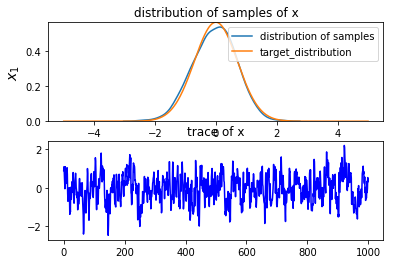

In [4]:
import seaborn as sns

plt.figure()
plt.subplot(2,1,1)
sns.kdeplot(x_trace[:,0],label='distribution of samples')
plt.plot(np.linspace(-5,5,500),np.exp(-np.linspace(-5,5,500)**2)/(np.pi)**0.5,label='target_distribution')
plt.title('distribution of samples of x')
plt.ylabel('$x_1$', fontsize=14)
plt.legend()
plt.subplot(2,1,2)
plt.plot(x_trace, 'b-')
plt.title('trace of x')

print("number of rejected samples: ",len(logs['rejected']))

Have a look at the number of rejected samples. Play around with the three parameters that can be tweaked
 - mass (the bigger the mass, the smaller the kicks => slower exploration of the state space)
 - number of leapfrog steps
 - size of leapfrog step
 
and see what happens.


Also have a look at the values of $x$ through which the system passed during leapfrog integration.
Can you explain why it looks like it does? What about energy log (```logs["E"]```)? What is the distribution of energy?

rejected samples: 4


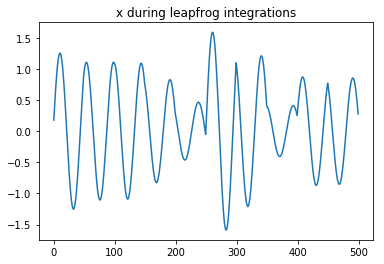

In [5]:
#number of rejected samples:
print('rejected samples:', len(logs['rejected']))

plt.figure()
plt.plot(logs['x'][:500])
_=plt.title('x during leapfrog integrations')

# Complicated multidimensional distribution
Let's try some more complicated distribution, which could be difficult to sample by random walk Metropolis.
The distribution is:

$$P(x)=e^{-a(r-1)^2 - b \cos(2 \phi) r}$$

Potential for it consists of two equaly deep curved valeys ( in the shape of "bratislavský rožok") at the bottom of a bowl.

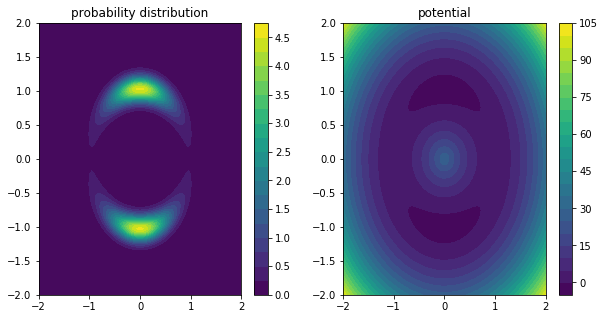

In [6]:
a=30.
b=1.5    #play around and try also the value b=6 (or higher). What will happen? How to solve that?

def fancy_potential(x):
    r=np.dot(x,x)**0.5
    if r<0.1:      #potential numerical instability?
        return a*(r-1)**2
    return a*(r-1)**2 + b*(x[0]**2-x[1]**2)/ r     #=a(r-1)**2+b*cos(2*phi)*r

def fancy_gradient(x):
    r=np.dot(x,x)**0.5
    if r<0.1:
        return np.array([0.,0.])
    dUdx=2*a*(r-1)*x[0]/r + b*(2*x[0]/r -(x[0]**2-x[1]**2)*x[0]/r**3)
    dUdy=2*a*(r-1)*x[1]/r + b*(-2*x[1]/r -(x[0]**2-x[1]**2)*x[1]/r**3)
    return np.array([dUdx,dUdy])

xg, yg = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
zg = np.zeros_like(xg)
for i,j in np.ndindex(xg.shape):
    zg[i,j] = fancy_potential(np.array([xg[i,j], yg[i,j]]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot1=plt.contourf(xg, yg, np.exp(-zg), 20, cmap=plt.cm.viridis)
plt.colorbar(plot1)
plt.title('probability distribution')
plt.subplot(1,2,2)
plot2=plt.contourf(xg, yg, zg, 20,cmap=plt.cm.viridis)
plt.colorbar(plot2)
_=plt.title('potential')

In [8]:
#number of leapfrog steps = 20, timestep = 0.1 and m=10 , number of samples=1000


sampler=HMC_sampler(fancy_potential,fancy_gradient,
                    num_leapfrog_steps=20,
                    leapfrog_stepsize=0.1,
                    mass=10)   

x_init=np.array([0.,0.1])
x_trace,logs=sampler.run(x_init,1000)
print('rejected: ', len(logs['rejected']))

rejected:  3


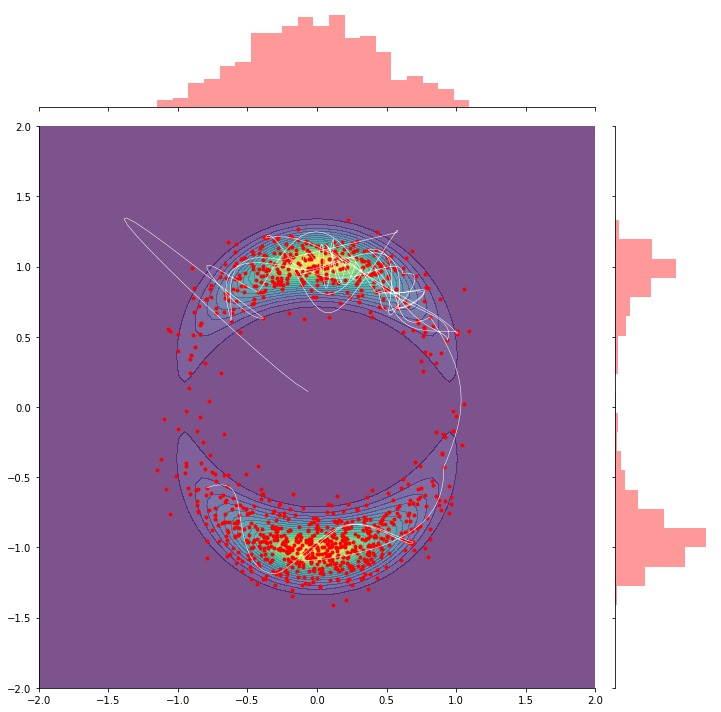

In [9]:
g = sns.JointGrid(x=x_trace[:,0], y=x_trace[:,1], size=10)
g.ax_joint.contourf(xg, yg, np.exp(-zg), 20, alpha=0.7, cmap=plt.cm.viridis)    #plotting probability distribution
#g.ax_joint.contourf(xg, yg, zg, 20, alpha= 0.7, cmap=plt.cm.viridis)    #plotting potential
g = g.plot_joint(plt.scatter, color="r",marker='.')
_ = g.ax_marg_x.hist(x_trace[:,0], color="r", alpha=.4, bins=20)
_ = g.ax_marg_y.hist(x_trace[:,1], color="r", alpha=.4, bins=20, orientation="horizontal")
x,y=zip(*logs['x'][:20*30])    #path of the first 30 leapfrog simulations
_=plt.plot(x,y,linewidth=0.5,color='w')

HMC sampler clearly follows the regions of high probability quite efficiently without almost any rejections. The white trajectory is trajectory traversed during leapfrogging and it can be clearly seen that it returns to the areas with low potential. Play around with it:
- try to change parameters a and b of the potential (set b to above 6)
- change mass, leapfrog_stepsize and num_leapfrog_steps

What exactly does changing the mass do? When does the sampler fail?

# Appendix

## Why is HMC better than random walk Metropolis in many dimensions?

TODO: read [3](https://arxiv.org/pdf/1206.1901.pdf)

In short: allmost no rejections, so the time to simulate hamiltonian dynamics is worth it.

## How to finetune it's parameters?

TODO: read [1](https://arxiv.org/pdf/1701.02434.pdf )

## When not to use HMC?

- unless you understand [5](https://arxiv.org/pdf/1705.08510.pdf), the HMC is usable only with *continuous* state space
- unless you understand [6](https://papers.nips.cc/paper/5801-reflection-refraction-and-hamiltonian-monte-carlo.pdf), the HMC is not suitable for non-smooth probability densities
- sharp changes in potential, even if smooth in theory, can lead to numerical instability during leapfrog integration
- If computation of gradient is difficult / numerically expensive
- Be carefull if the target distribution have multiple islands with very high probability, since the HMC may become trapped in one of them. Carefull finetuning may take care of that, or you can use HMC with time dependent temperature (tempering).
- If the probability is exactly zero anywhere. But I believe there exist constrained variations of HMC. Also, reflections at the borders of the area with zero probability as in [6] or change of parametrisation could solve that.
- if the number of dimensions is low and the shape of target distribution simple.

## Choice of kinetic energy and momentum sampling distribution

When choosing a suitable hamiltonian, you don't have to constraint yourself to a particle in a potential field ( $H = U(x)+ \frac{1}{2}mv^2$) as we did in this notebook. Only the potential energy $U(x)$ is constrained by it's relationship with the target probability density $U(x)=-log(P(x))$, so it seems you can pick as your kinetic energy any function $K(x,p)$. That is true, but you would have to change the resampling distribution of momentum accordingly. For in depth explanation, see [1](https://arxiv.org/pdf/1701.02434.pdf). In short:

You want to sample from $P(x)$, which is difficult.  
You add new variable $p$.  
Instead of sampling $x$ you sample tuples $(x,p)$ from distribution $P(x,p)$ such, that $P(x)=\int P(x,p) dp$  
In other words, $P(x,p)=P(p|x)P(x)$  
We introduce new function conveniently named $H(x,p)$ such that $P(x,p)=e^{-H(x,p)}$  
From the equations above, we get $H(x,p)=-log(P(p | x))-log(P(x))=K(x,p)+V(x)$

Keep in mind that all introduced functions are just arbitrally functions devised to reproduce our target probability distribution and any analogy with physical energies is purely coincidental ([link](https://vignette.wikia.nocookie.net/zootopia/images/7/74/Coincidence-i-think-not.jpg/revision/latest/scale-to-width-down/640?cb=20160507025359)).

TODO: hmm, it feels like some step is missing here, see [1]

However we already see that kinetic energy must be equal to $K(x,p)=-log(P(p|x))$, so by choosing some $K(x,p)$, we allready define the probability distribution of momentum. Our sampler must respect this constraint, so the momentum must be sampled from the distribution $P(p|x)=e^{-K(x,p)}$.

By choosing $K(x,p)=\frac{1}{2}mv^2$, we get gaussian sampling distribution (which is nice). We could theoretically prefer different sampling distribution, in which case we would have to pick kinetic energy term accordingly.

However, kinetic energy dependent on both $x$ and $p$ should probably be avoided in practice, since the leapfrog algorithm is not time reversible in such case [citation or proof needed].

If you want experimental proof that the kinetic energy function and velocity sampling distribution are interdependent, check out the HMC_sampler implementation and try to rescale one of them (but not the other) and see what happens.


# Further reading

The best paper ever:
[1] https://arxiv.org/pdf/1701.02434.pdf  
Also good, but only one can be the best:
[2] http://www.cs.toronto.edu/~radford/ftp/review.pdf  
Paper with good treatment of HMC advantages:
[3] https://arxiv.org/pdf/1206.1901.pdf  
Where does the Boltzman distribution comes from in physics:
[4] http://assets.cambridge.org/97805218/11194/excerpt/9780521811194_excerpt.pdf  

Variants of HMC for discrete space state and discontinuous probability density:  
[5] https://arxiv.org/pdf/1705.08510.pdf  
[6] https://papers.nips.cc/paper/5801-reflection-refraction-and-hamiltonian-monte-carlo.pdf

Some gentler reading and nice pictures:  
https://am207.github.io/2017/wiki/hmcexplore.html  
http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html